In [7]:
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import sys
import os
import seaborn as sns
import pandas as pd
import mpmath as mp
from scipy.optimize import fsolve

import mwc_induction_utils as mwc
mwc.set_plotting_style()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

colors=sns.color_palette('colorblind').as_hex()
colors[4] = sns.xkcd_palette(['dusty purple']).as_hex()[0]
sns.set_palette(colors)

## Summation Strategy

The purpose of this notebook is to examine our model's predictions for titration curves in which multiple promoters are present. We begin with the example of the occupancy of identical promoters with multiplicity N, using summations. 

In [2]:
def fold_change(IPTG, K_A, K_I, e_AI, R, Op):
    '''
    Computes fold-change for simple repression
    Parameters
    ----------
    IPTG : array-like
        Array of IPTG concentrations in uM
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    R : float
        Number of repressors per cell
    Op : float
        Operator binding energy
    Returns
    -------
    probability that repressor is active
    '''
    return 1 / (1 + R / 4.6E6 * pact(IPTG, K_A, K_I, e_AI) * np.exp(-Op))

In [3]:
# Now define fold change function for variable N

# First need p_active
def pact(IPTG, K_A, K_I, e_AI):
    '''
    Computes the probability that a repressor is active
    Parameters
    ----------
    IPTG : array-like
        Array of IPTG concentrations in uM
    K_A : float
        Dissociation constant for active repressor
    K_I : float
        Dissociation constant for inactive repressor
    e_AI : float
        Energetic difference between the active and inactive state
    Returns
    -------
    probability that repressor is active
    '''
    pact = (1 + IPTG * 1 / K_A)**2 / \
    (((1 + IPTG * 1 / K_A))**2 + np.exp(-e_AI) * (1 + IPTG * 1 / K_I)**2)
    return pact

def fold_change_var_N(IPTG, K_A, K_I, R, e_AI, N, Op):
    '''
    Computes the fold-change for N >= 1
    Parameters
    ----------
    Reff : array-like
        Array with the values of all repressor copy numbers
    e_AI : float
        Energetic difference between the active and inactive state
    N : float
        Number of operators available for repressor binding
    Op : float
        Binding energy between operator and repressor as inferred in Garcia 2011
    Returns
    -------
    fold-change
    '''

    NNS = 4.6E6    #Number of nonspecific sites
    fc = []      #This will be my fold-change array
    
    for c in IPTG:
        pA = pact(c, K_A, K_I, e_AI)    #probability that a given repressor is active
        Reff = R * pA

        t = 0
        b = 0
        for m in range(0, min(int(mp.floor(Reff)), int(mp.floor(N)))+1):
            t += mp.fprod([mp.fdiv(mp.factorial(mp.floor(Reff)), mp.fmul(mp.mpf(NNS)**m, mp.factorial(mp.floor(Reff - m)))), mp.binomial(mp.floor(N),m), mp.exp(-m*Op), mp.floor(N)-mp.mpf(m)])
            b += mp.fprod([mp.fdiv(mp.factorial(mp.floor(Reff)), mp.fmul(mp.mpf(NNS)**m, mp.factorial(mp.floor(Reff - m)))), mp.binomial(mp.floor(N),m), mp.exp(-m*Op)])
        fc.append(float(t/(mp.floor(N)*b)))
    return fc

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


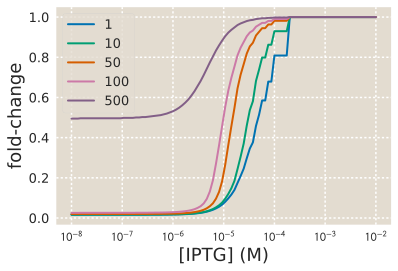

In [4]:
K_A = 139E-6
K_I = 0.53E-6
e_AI = 4.5
R = 260
Op = -13.9
IPTG = np.logspace(-8, -2, 100)
N_vals = [1, 10, 50, 100, 500]

#plt.plot(IPTG, fold_change(IPTG, K_A, K_I, e_AI, R, Op), label = 1)
for i, N in enumerate(N_vals):
    fc = fold_change_var_N(IPTG, K_A, K_I, R, e_AI, N, Op)
    plt.plot(IPTG, fc, color=colors[i], label=N)
plt.xscale('log')
plt.legend()
plt.xlabel('[IPTG] (M)')
plt.ylabel('fold-change')
#plt.yscale('log')

plt.savefig('multiple_copies_titration_discrete.pdf', bbox_inches='tight')

## Chemical Potential Strategy

The better strategy may be to just solve for the chemical potential. We start with the multiple promoter copies model.

In [8]:
def chem_potential(IPTG, R, Ns, e_s, K_A=139E-6, K_I=0.53E-6, e_AI=4.5, Nc=0, e_c=0):
    '''
    Solves for the chemical potential of simple repression with 
    multiple promoter copies (Ns, with energy e_s) or competitor sites
    (Nc, with energy e_c).
    '''
    NNS = 4.6E6
    lam = []
    func = lambda x: -Reff + Ns*(x * np.exp(-e_s))/(1 + x * np.exp(-e_s)) +\
                         NNS * (x)/(1 + x) + \
                         Nc*(x * np.exp(-e_c))/(1 + x * np.exp(-e_c))
    for c in IPTG:
        Reff = R * pact(c, K_A, K_I, e_AI)
        x = Symbol('x')
        lam.append(fsolve(func, 0))
    return np.array(lam)

def occupancy(lam, Op):
    '''
    Computes fold change for simple repression using the chemical potential (lam).
    '''
    return 1/(1 + lam * np.exp(-(Op)))

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


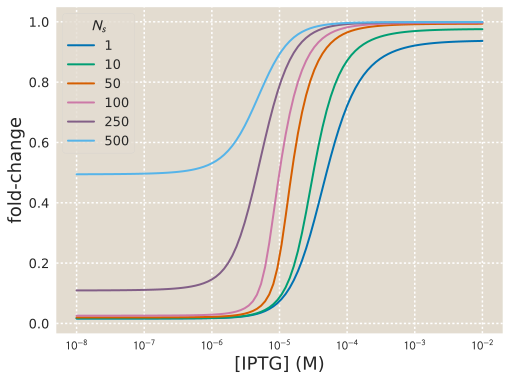

In [9]:
# Test case: multiple promoters, no competitors

IPTG = np.logspace(-8, -2, 100)
R = 260
N_vals = [1, 10, 50, 100, 250, 500]
Op = -13.9

plt.figure(figsize=(8,6))
for N in N_vals:
    lam_array = chem_potential(IPTG, R, N, Op)
    fc = occupancy(lam_array, Op)
    plt.plot(IPTG, fc, label = N)
plt.xscale('log')
plt.xlabel('[IPTG] (M)')
plt.ylabel('fold-change')
leg = plt.legend(title=r'$N_s$')
leg.get_title().set_fontsize(15)

#plt.savefig('multiple_copies_titration_draft.pdf', bbox_inches='tight')

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


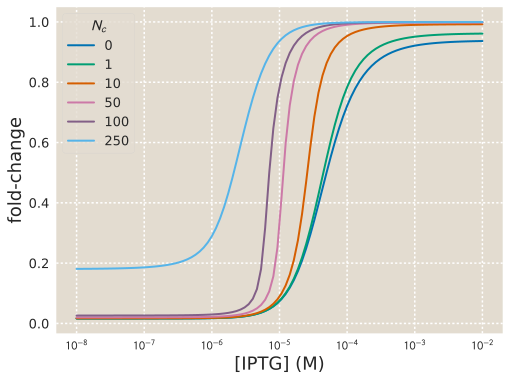

In [11]:
# Test case: one promoter, competitors

IPTG = np.logspace(-8, -2, 100)
R = 260
N_vals = [1]
Op = -13.9
Nc = [0, 1, 10, 50, 100, 250]
e_c = -15.3

plt.figure(figsize=(8,6))
for N in Nc:
    lam_array = chem_potential(IPTG, R, Ns=N_vals, e_s=Op, Nc=N, e_c=e_c)
    fc = occupancy(lam_array, Op)
    plt.plot(IPTG, fc, label = N)
plt.xscale('log')
plt.xlabel('[IPTG] (M)')
plt.ylabel('fold-change')
leg = plt.legend(title=r'$N_c$')
leg.get_title().set_fontsize(15)

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


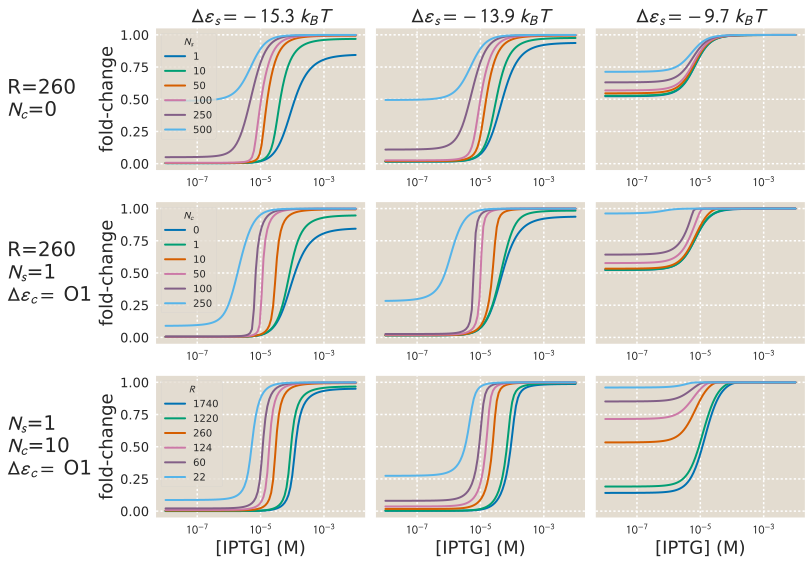

In [45]:
# First row: R = 260, e_s is O1, O2, or O3, N_s varies from 1 to 500
# Second row: R = 260, e_s is O1, O2, or O3, N_s is 1, N_c varies from 1 to 250, e_c is O1
# Third row: Ns = 10, e_s is O1, O2, or O3, R varies from 22 to 1740

ops = [-15.3, -13.9, -9.7]
reps = [1740, 1220, 260, 124, 60, 22]
Ns = [1, 10, 50, 100, 250, 500]
Nc = [0, 1, 10, 50, 100, 250]
IPTG = np.logspace(-8, -2, 100)
e_c = -17.0
R=260

fig, ax = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(10, 8))

for i, a in enumerate(ax[0]):
    for N in Ns:
        lam_array = chem_potential(IPTG, R, Ns=N, e_s=ops[i])
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=N)
    a.set_xscale('log')
    a.set_title(r'$\Delta \varepsilon_s= %0.1f\ k_BT$' % ops[i])
ax[0][0].set_ylabel('fold-change')
ax[0][0].text(1E-13, 0.5, 'R=260 \n$N_c$=0', va='center', fontsize=20)
leg1 = ax[0][0].legend(title=r'$N_s$', fontsize=10, loc='upper left')
leg1.get_title().set_fontsize(10)
    
for i, a in enumerate(ax[1]):
    for N in Nc:
        lam_array = chem_potential(IPTG, R, Ns=Ns[0], e_s=ops[i], Nc=N, e_c=e_c)
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=N)
    a.set_xscale('log')
ax[1][0].set_ylabel('fold-change')
ax[1][0].text(1E-13, 0.5, 'R=260 \n$N_s$=1 \n$\Delta \epsilon_c=$ O1', va='center', fontsize=20)
leg2 = ax[1][0].legend(title=r'$N_c$', fontsize=10, loc='upper left')
leg2.get_title().set_fontsize(10)
    
for i, a in enumerate(ax[2]):
    for rep in reps:
        lam_array = chem_potential(IPTG, rep, Ns=Ns[0], e_s=ops[i], Nc=10, e_c=e_c)
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=rep)
    a.set_xscale('log')   
    a.set_xlabel('[IPTG] (M)')
ax[2][0].set_ylabel('fold-change')
ax[2][0].text(1E-13, 0.5, '$N_s$=1 \n$N_c$=10 \n$\Delta \epsilon_c=$ O1', va='center', fontsize=20)
leg3 = ax[2][0].legend(title=r'$R$', fontsize=10, loc='upper left')
leg3.get_title().set_fontsize(10)
    
    
plt.tight_layout()
plt.savefig('fugacity_draft.pdf', bbox_inches='tight')

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


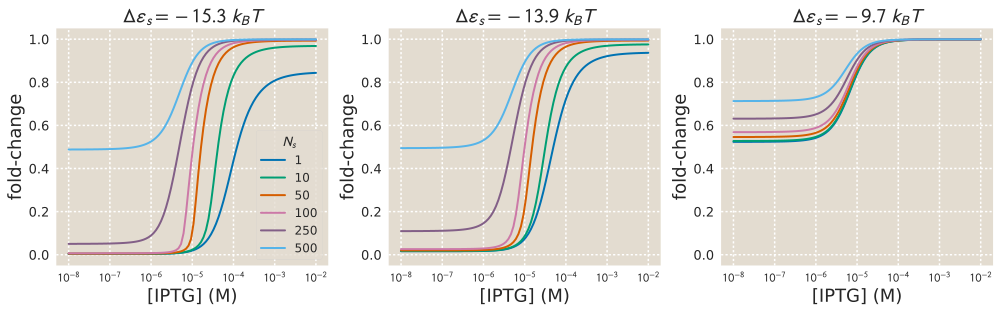

In [36]:
# Plot rows separately for ease of use in writeup

ops = [-15.3, -13.9, -9.7]
reps = [1740, 1220, 260, 124, 60, 22]
Nc = [1, 10, 50, 100, 250, 500]
IPTG = np.logspace(-8, -2, 100)
R=260

fig, ax = plt.subplots(ncols=3,  sharey=False, figsize=(14, 4.5))

for i, a in enumerate(ax):
    for N in Ns:
        lam_array = chem_potential(IPTG, R, Ns=N, e_s=ops[i])
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=N)
    a.set_xscale('log')
    a.set_title(r'$\Delta \varepsilon_s= %0.1f\ k_BT$' % ops[i])
    a.set_ylabel('fold-change')
    a.set_ylim(-0.05,1.05)
    a.set_xlabel('[IPTG] (M)')

leg1 = ax[0].legend(title=r'$N_s$', fontsize=12, loc='lower right')
leg1.get_title().set_fontsize(14)

plt.tight_layout()
plt.savefig('fugacity_Ns.pdf', bbox_inches='tight')

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


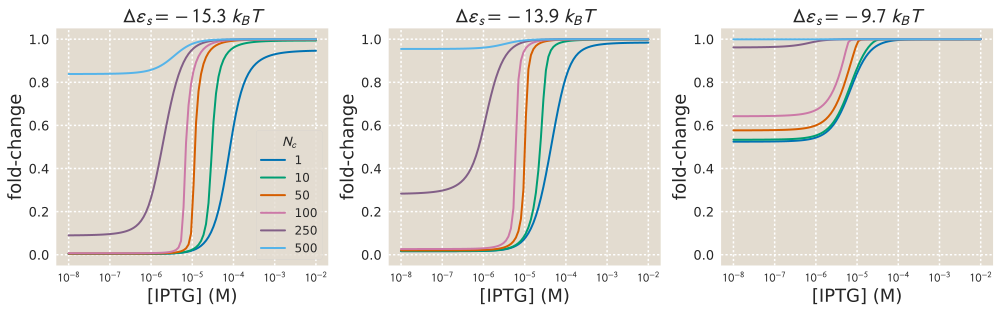

In [47]:
fig, ax = plt.subplots(ncols=3,  sharey=False, figsize=(14, 4.5))
Nc = [1, 10, 50, 100, 250, 500]
e_c = -17.0

for i, a in enumerate(ax):
    for N in Nc:
        lam_array = chem_potential(IPTG, R, Ns=1, e_s=ops[i], Nc=N, e_c=e_c)
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=N)
    a.set_xscale('log')
    a.set_title(r'$\Delta \varepsilon_s= %0.1f\ k_BT$' % ops[i])
    a.set_ylabel('fold-change')
    a.set_xlabel('[IPTG] (M)')
    a.set_ylim(-0.05,1.05)

leg1 = ax[0].legend(title=r'$N_c$', fontsize=12, loc='lower right')
leg1.get_title().set_fontsize(14)

plt.tight_layout()
plt.savefig('fugacity_Nc.pdf', bbox_inches='tight')

/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


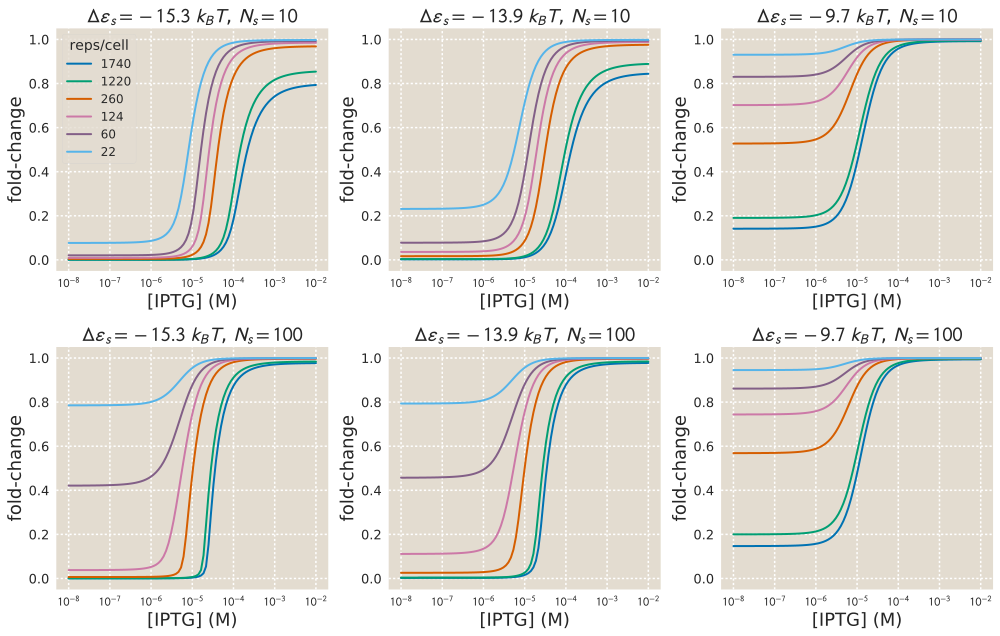

In [44]:
fig, ax = plt.subplots(ncols=3, nrows=2, sharey=False, figsize=(14, 9))

for i, a in enumerate(ax[0]):
    for rep in reps:
        lam_array = chem_potential(IPTG, rep, Ns=10, e_s=ops[i])
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=rep)
    a.set_xscale('log')
    a.set_title(r'$\Delta \varepsilon_s= %0.1f\ k_BT$, $N_s=10$' % ops[i])
    a.set_ylabel('fold-change')
    a.set_xlabel('[IPTG] (M)')
    a.set_ylim(-0.05,1.05)
    
for i, a in enumerate(ax[1]):
    for rep in reps:
        lam_array = chem_potential(IPTG, rep, Ns=100, e_s=ops[i])
        fc = occupancy(lam_array, ops[i])
        a.plot(IPTG, fc, label=rep)
    a.set_xscale('log')
    a.set_title(r'$\Delta \varepsilon_s= %0.1f\ k_BT$, $N_s=100$' % ops[i])
    a.set_ylabel('fold-change')
    a.set_xlabel('[IPTG] (M)')
    a.set_ylim(-0.05,1.05)

leg1 = ax[0][0].legend(title='reps/cell', fontsize=12, loc='upper left')
leg1.get_title().set_fontsize(14)

plt.tight_layout()
plt.savefig('fugacity_R.pdf', bbox_inches='tight')